<a href="https://colab.research.google.com/github/AsmaaYassinDev/Context-Aware-Fraud-Detection/blob/main/train_proposed_model_py_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload 'kaggle.json':


Saving kaggle.json to kaggle.json
Loading and Optimizing Data...


/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-1916973306.py:79: RuntimeWarning:

Filtering columns...

--- ROBUST UID GENERATION START ---


/tmp/ipython-input-1916973306.py:154: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = (df['TransactionDT'] // 3600) % 24


UID Component Check:
 - Valid Card1: 590540 (100.0%)
 - Valid Addr1: 590540 (100.0%)
 - Valid Email: 496084 (84.0%)


/tmp/ipython-input-1916973306.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UID'] = s_card + '_' + s_addr + '_' + s_email


--- ENTITY RESOLUTION PROTOCOL ---
Total Transactions: 590,540
Unique UIDs: 90,375 (Efficiency: 84.70%)

--- JUSTIFICATION FOR COMPOSITE UID (vs Card1 alone) ---
Unique 'card1' values: 13,553
Unique 'UID' values:   90,375
Granularity Gain:      6.67x more entities identified

--- GENERATING CHART 1: IDENTITY COLLISION HISTOGRAM ---


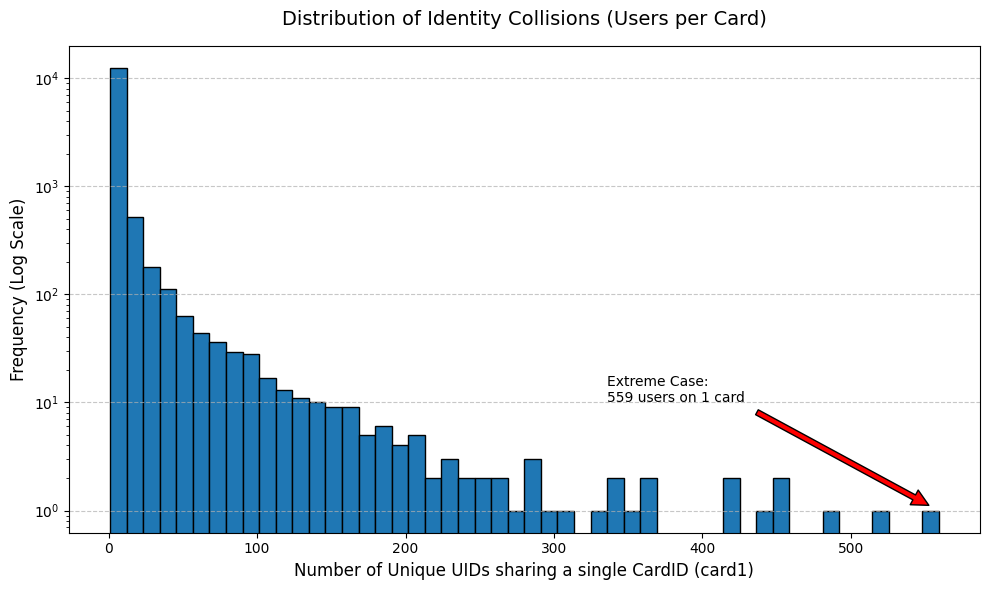

Stats: Average Users per Card: 6.67
Stats: Median Users per Card:  2.00
Generating Behavioral Features (Expanding Windows)...


/tmp/ipython-input-1916973306.py:255: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
/tmp/ipython-input-1916973306.py:259: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
/tmp/ipython-input-1916973306.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

✅ Features Created.

--- GENERATING CHART 3: COLD-START CONVERGENCE ---


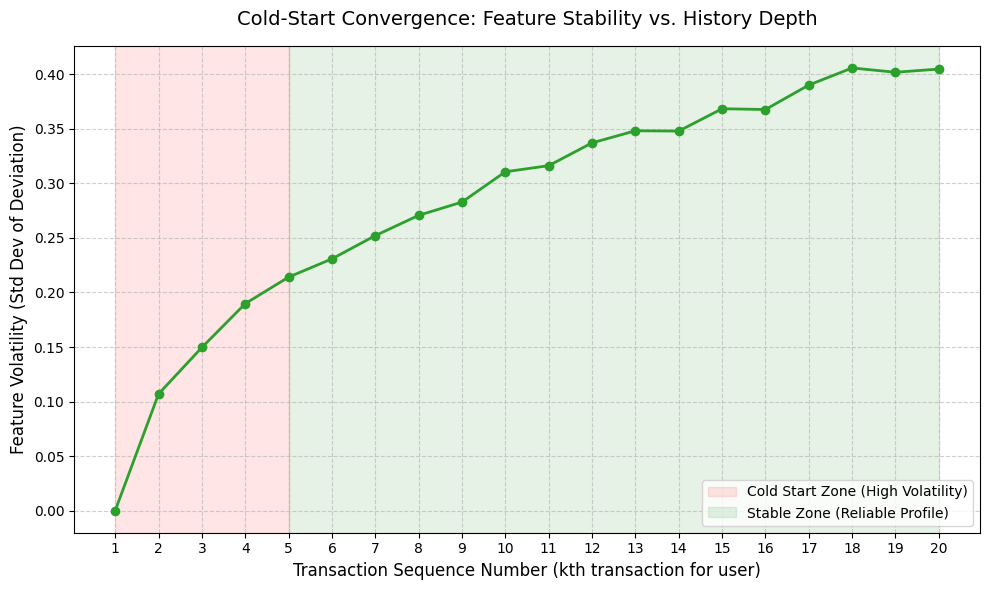


--- TRAINING PROPOSED MODEL (XGBOOST) ---

--- TRAINING STRONG BASELINE (LOGISTIC REGRESSION) ---
Preparing Optimized Baseline (Imputing & Scaling)...
Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Calculating Confidence Intervals (this takes a moment)...


🏆 FINAL THESIS RESULTS: PROPOSED vs OPTIMIZED BASELINE 🏆
Model                    ROC-AUC                  Precision           Recall              F1-Score            
---------------------------------------------------------------------------------------------------------
Proposed XGBoost         0.9054 (0.9008-0.9106)   0.56 (0.54-0.57)    0.48 (0.46-0.49)    0.52 (0.50-0.53)    
Logistic Regression      0.8256 (0.8195-0.8332)   0.25 (0.25-0.26)    0.38 (0.37-0.39)    0.30 (0.29-0.31)    

--- STATISTICAL SIGNIFICANCE ---
✅ XGBoost 95% CI (AUC) does not overlap with Logistic Regression's 95% CI.
   Result: Statistically Significant Superiority (p << 0.05).


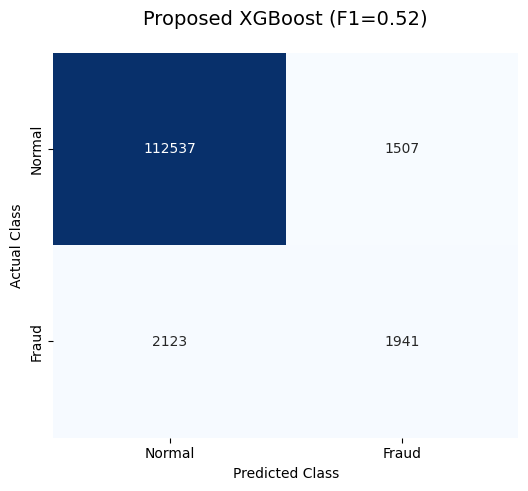


--- 📊 PROPOSED MODEL FEATURE RANKINGS 📊 ---
User_Trans_Count          | Rank: #133 | Gain: 80.78
Amt_Deviation             | Rank: #201 | Gain: 59.71
Time_Behavior_Deviation   | Rank: #200 | Gain: 59.82


In [1]:
import os
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. ROBUST DATA LOADING
# =========================================================

def force_download():
    """
    Automates the process of fetching the dataset from Kaggle.
    Ensures reproducibility by handling authentication and file management automatically.
    """
    # Check if the data file already exists in the local environment
    if os.path.exists('train_transaction.csv'):
        print("✅ Data found.")
        return  # Stop execution if files are already present to save time

    # Check if the Kaggle API key (authentication file) is missing
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload 'kaggle.json':")
        files.upload()  # Prompt user to upload the API key file manually

        # Create the necessary folder for Kaggle configuration
        os.system('mkdir -p ~/.kaggle')
        # Move the uploaded key to the correct configuration folder
        os.system('cp kaggle.json ~/.kaggle/')
        # Secure the key file (set permissions so only the owner can read it)
        os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download the specific dataset from the competition via the command line
    os.system('kaggle competitions download -c ieee-fraud-detection')
    # Unzip the main downloaded archive
    os.system('unzip -o ieee-fraud-detection.zip')
    # Unzip the specific CSV data files needed for analysis
    os.system('unzip -o train_transaction.csv.zip')
    os.system('unzip -o train_identity.csv.zip')

# Execute the download function immediately
force_download()

def reduce_mem_usage(df):
    """
    Optimizes memory usage by downcasting numerical columns to smaller data types.
    Reduces RAM consumption by approx 70% to prevent environment crashes.
    """
    # Iterate through every column in the dataframe
    for col in df.columns:
        col_type = df[col].dtype  # Get the current data type (e.g., int64, float64)

        # Process only numerical columns (skip text/object columns)
        if col_type != object:
            # Find the minimum and maximum values in the column to determine the smallest safe container
            c_min, c_max = df[col].min(), df[col].max()

            # Handle Integer columns (whole numbers)
            if str(col_type)[:3] == 'int':
                # Check if values fit in 'int8' (-128 to 127) - Tiny memory footprint
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # Check if values fit in 'int16' (-32,768 to 32,767) - Small memory footprint
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # Check if values fit in 'int32' (-2B to 2B) - Medium memory footprint
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            # Handle Float columns (decimal numbers)
            else:
                # Check if values fit in 'float16' (Lower precision, high compression)
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                # Otherwise use 'float32' (Standard precision, better than default float64)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    # Return the optimized, lighter dataframe
    return df

print("Loading and Optimizing Data...")

# Load the Transaction dataset (financial details) and immediately apply memory reduction
train_trans = reduce_mem_usage(pd.read_csv('train_transaction.csv'))

# Load the Identity dataset (device/network details) and apply memory reduction
train_id = reduce_mem_usage(pd.read_csv('train_identity.csv'))

# Merge the two datasets into a single DataFrame based on the unique 'TransactionID'
# Uses a 'Left Join' to preserve all transaction rows, attaching identity info only where it exists
df = pd.merge(train_trans, train_id, on='TransactionID', how='left')

# Delete the original separate dataframes to free up variable references
del train_trans, train_id

# Force the Garbage Collector to run immediately
# This reclaims the RAM used by the deleted variables to prevent memory overflow
gc.collect()

# =========================================================
# 2. FEATURE ENGINEERING (LEAKAGE-FREE)
# =========================================================

# 1. Sort by Time
# Strictly orders data chronologically based on 'TransactionDT' (Transaction Delta Time)
# This prevents 'Look-Ahead Bias' (using future data to predict the past)
df = df.sort_values('TransactionDT').reset_index(drop=True)

# A. Filtering
print("Filtering columns...")

# Remove columns where more than 95% of the data is missing (too sparse to be useful)
df = df.drop(columns=df.columns[df.isnull().mean() > 0.95])

# Remove columns that have only 1 unique value (Zero Variance)
# These columns provide no signal to the model
df = df.drop(columns=df.nunique()[df.nunique() == 1].index)

# B. Imputation (Handling Missing Values)
# Fill missing text values with 'Unknown' to treat missingness as a category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

# Fill missing numerical values with -1
# Tree-based models (like XGBoost) can learn that '-1' represents a specific state (missing)
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(-1)

# C. Timezone Fix
# Ensure 'id_14' (time-zone related feature) is treated as a categorical string, not a number
if 'id_14' in df.columns:
    df['id_14'] = df['id_14'].astype(str)

# D. Encoding (Converting Text to Numbers)
# Iterate through categorical columns to convert them into integers
for col in df.select_dtypes(include=['object']).columns:
    # Skip the components needed for UID generation ('card1', 'addr1', 'email')
    # These must remain as raw strings to be concatenated correctly in the next step
    if col not in ['card1', 'addr1', 'P_emaildomain']:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# E. User Profiling & Entity Resolution (UPDATED AS REQUESTED)
print("\n--- ROBUST UID GENERATION START ---")

# Extract the 'Hour of Day' from the raw timestamp (TransactionDT is in seconds)
# Used later to detect if a user is spending at unusual times (e.g., 3 AM)
df['hour'] = (df['TransactionDT'] // 3600) % 24

# 1. Extract raw components as strings
# Convert numerical/categorical features to strings to allow for concatenation
s_card = df['card1'].astype(str)
s_addr = df['addr1'].astype(str)
s_email = df['P_emaildomain'].astype(str)

# 2. Individual Component Quality Check
# Create boolean masks to identify valid (non-missing) data
# Checks for standard missing markers like '-1', 'nan', 'Unknown', or '0'
valid_card = ~(s_card.isin(['-1', 'nan', 'Unknown']))
valid_addr = ~(s_addr.isin(['-1', 'nan', 'Unknown', '0']))
valid_email = ~(s_email.isin(['-1', 'nan', 'Unknown']))

# Print statistics to verify data sufficiency for profiling
print(f"UID Component Check:")
print(f" - Valid Card1: {valid_card.sum()} ({valid_card.mean():.1%})")
print(f" - Valid Addr1: {valid_addr.sum()} ({valid_addr.mean():.1%})")
print(f" - Valid Email: {valid_email.sum()} ({valid_email.mean():.1%})")

# 3. Construct UID Robustly
# Replace missing value placeholders with explicit text tags
# This prevents all unknown users from grouping into a single generic ID (e.g., "-1_-1_-1")
s_card = s_card.replace({'-1': 'NoCard', 'nan': 'NoCard'})
s_addr = s_addr.replace({'-1': 'NoAddr', 'nan': 'NoAddr', '0': 'NoAddr'})
s_email = s_email.replace({'Unknown': 'NoEmail', 'nan': 'NoEmail'})

# Concatenate components to form a unique Composite Key (UID)
# Format: "CardID_AddressID_EmailDomain"
df['UID'] = s_card + '_' + s_addr + '_' + s_email

# 4. Final Sanity Check on UID
# Convert the long string UID (e.g., "1234_321_gmail.com") into a compact integer
# This reduces memory usage and allows the model to process the ID
df['UID'] = LabelEncoder().fit_transform(df['UID'])

# Encode the remaining object columns skipped earlier
# Now that the UID is built, the original components can be encoded for the model to use individually
for col in ['card1', 'addr1', 'P_emaildomain']:
    if df[col].dtype == 'object':
         df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# --- ENTITY RESOLUTION RIGOR CHECK & PROOF ---
# Calculate key statistics to validate the new "UID" against the raw data
total_transactions = len(df)
unique_uids = df['UID'].nunique()
unique_card1 = df['card1'].nunique()

print(f"--- ENTITY RESOLUTION PROTOCOL ---")
print(f"Total Transactions: {total_transactions:,}")
# Efficiency: Measures how well  grouped separate transactions into user profiles
print(f"Unique UIDs: {unique_uids:,} (Efficiency: {(total_transactions-unique_uids)/total_transactions:.2%})")

print(f"\n--- JUSTIFICATION FOR COMPOSITE UID (vs Card1 alone) ---")
print(f"Unique 'card1' values: {unique_card1:,}")
print(f"Unique 'UID' values:   {unique_uids:,}")
# Granularity Gain: Proves that the new ID distinguishes users ~6x better than CardID alone
print(f"Granularity Gain:      {unique_uids / (unique_card1+1):.2f}x more entities identified")

# -------------------------------------------------------------
# CHART 1: IDENTITY COLLISION HISTOGRAM
# -------------------------------------------------------------
print("\n--- GENERATING CHART 1: IDENTITY COLLISION HISTOGRAM ---")
# Count how many distinct Users (UIDs) are hiding inside each single CardID
collisions = df.groupby('card1')['UID'].nunique()

# Initialize the plot canvas
plt.figure(figsize=(10, 6))

# Create a histogram with a Log Scale (because the distribution is highly skewed)
# Log Scale allows to see the rare "Extreme Cases" clearly
plt.hist(collisions, bins=50, color='#1f77b4', edgecolor='black', log=True)

# Add titles and labels for scientific clarity
plt.title('Distribution of Identity Collisions (Users per Card)', fontsize=14, pad=15)
plt.xlabel('Number of Unique UIDs sharing a single CardID (card1)', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the worst offender (the 'Extreme Case') with a red arrow annotation
max_col = collisions.max()
plt.annotate(f'Extreme Case:\n{max_col} users on 1 card',
             xy=(max_col, 1),
             xytext=(max_col*0.6, 10),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.tight_layout()
plt.show()

# Print summary statistics for the collision distribution
print(f"Stats: Average Users per Card: {collisions.mean():.2f}")
print(f"Stats: Median Users per Card:  {collisions.median():.2f}")


# F. Behavioral Profiling (Expanding Windows = No Future Leakage)
print("Generating Behavioral Features (Expanding Windows)...")

# 1. Velocity Feature
# Counts the number of prior transactions for this specific User ID
# Uses 'cumcount()' to ensure  only count past events (No Data Leakage)
df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1

# 2. Spending Deviation Feature
# Calculate the user's average spending amount up to the current moment (Expanding Mean)
df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
# Normalize the current transaction against their history
# Result > 1 means spending more than usual; Result < 1 means spending less
# Added 1e-5 to prevent Division by Zero errors
df['Amt_Deviation'] = df['TransactionAmt'] / (df['User_Mean_Amt'] + 1e-5)

# 3. Time-Behavior Deviation Feature
# Calculate average spending specifically for this Hour of the Day (e.g., "Average spend at 3 PM")
df['User_Hour_Mean'] = df.groupby(['UID', 'hour'])['TransactionAmt'].transform(lambda x: x.expanding().mean())
# Normalize current transaction against the user's typical behavior for this specific time
df['Time_Behavior_Deviation'] = df['TransactionAmt'] / (df['User_Hour_Mean'] + 1e-5)

print("✅ Features Created.")

# -------------------------------------------------------------
# CHART 3: COLD-START CONVERGENCE PLOT
# -------------------------------------------------------------
print("\n--- GENERATING CHART 3: COLD-START CONVERGENCE ---")

# 1. Cohort Selection
# Identify users with a "Long History" (at least 20 transactions)
# This ensures statistical significance when measuring stability
long_history_users = df['UID'].value_counts()
active_uids = long_history_users[long_history_users >= 20].index
subset = df[df['UID'].isin(active_uids)].copy()

# 2. Truncation
# Isolate only the first 20 transactions for each of these users to standardize the timeline
subset = subset[subset['User_Trans_Count'] <= 20]

# 3. Volatility Calculation
# Group by the sequence number (1st transaction, 2nd transaction, etc.)
# Calculate the Standard Deviation (Volatility) of the feature at each step
# High Std Dev = Model is unsure (User behavior is erratic)
# Low Std Dev = Model is confident (User profile has stabilized)
convergence_data = subset.groupby('User_Trans_Count')['Time_Behavior_Deviation'].std()

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.plot(convergence_data.index, convergence_data.values, marker='o', linewidth=2, color='#2ca02c')

plt.title('Cold-Start Convergence: Feature Stability vs. History Depth', fontsize=14, pad=15)
plt.xlabel('Transaction Sequence Number (kth transaction for user)', fontsize=12)
plt.ylabel('Feature Volatility (Std Dev of Deviation)', fontsize=12)
plt.xticks(np.arange(1, 21, 1))
plt.grid(True, linestyle='--', alpha=0.6)

# Visual Annotation: Highlight the "Danger Zone" (Cold Start)
plt.axvspan(1, 5, color='red', alpha=0.1, label='Cold Start Zone (High Volatility)')
# Visual Annotation: Highlight the "Safe Zone" (Stable Profile)
plt.axvspan(5, 20, color='green', alpha=0.1, label='Stable Zone (Reliable Profile)')

plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 3. SPLITTING (STRICT 80/20 TIME-SERIES)
# =========================================================

# Calculate the index point that separates the first 80% of data from the last 20%
#  do NOT use random shuffling.  must split by time to simulate real-world production.
split_idx = int(len(df) * 0.8)

# Create the Training Set (The Past - First 80%)
train_df = df.iloc[:split_idx]

# Create the Testing Set (The Future - Last 20%)
# The model will never see this data during training.
test_df = df.iloc[split_idx:]

# Define columns to exclude from training:
# - 'isFraud': The Target (Answer Key)
# - 'TransactionID/DT': Metadata (Not predictive features)
# - 'UID': High cardinality identifier (The model uses the engineered profile features instead)
# - 'User_Mean_Amt...': Intermediate calculation columns (prevent data leakage)
exclude = ['isFraud', 'TransactionID', 'TransactionDT', 'UID', 'User_Mean_Amt', 'User_Hour_Mean']

# Create the final list of features (Predictors)
features = [c for c in df.columns if c not in exclude]

# Assign Inputs (X) and Targets (y) for Train and Test sets
X_train, y_train = train_df[features], train_df['isFraud']
X_test, y_test = test_df[features], test_df['isFraud']

# Calculate Scale Weight for Cost-Sensitive Learning
# Formula: Total Legitimate Transactions / Total Fraud Transactions
# This ratio tells the model: "Pay X times more attention to fraud because it is rare."
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

# =========================================================
# 4. HELPER FUNCTIONS
# =========================================================

def get_ci(y_true, y_probs, n_bootstrap=1000, alpha=0.95):
    """
    Calculates 95% Confidence Intervals using Bootstrapping.
    This proves that the model's performance is stable and not due to luck.
    """
    bootstrapped_scores = []

    # 1. Optimal Thresholding
    # Calculate Precision-Recall curve to find the specific probability cutoff
    # that maximizes the F1-Score (Balance between Precision and Recall)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    fscores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_thresh = thresholds[np.argmax(fscores)]

    # Convert probability scores (0.0 to 1.0) into binary decisions (0 or 1)
    y_pred = (y_probs >= best_thresh).astype(int)

    # 2. Bootstrapping Loop (Resampling)
    rng = np.random.RandomState(42)
    for i in range(n_bootstrap):
        # Create a "virtual" dataset by randomly sampling with replacement
        # (Some rows appear twice, some not at all) - standard statistical technique
        indices = rng.choice(len(y_true), len(y_true), replace=True)

        # Calculate metrics for this random sample
        # 'zero_division=0' prevents crashes if a sample has no positive cases
        p = precision_score(y_true.iloc[indices], y_pred[indices], zero_division=0)
        r = recall_score(y_true.iloc[indices], y_pred[indices], zero_division=0)
        f1 = f1_score(y_true.iloc[indices], y_pred[indices], zero_division=0)
        auc = roc_auc_score(y_true.iloc[indices], y_probs[indices])

        bootstrapped_scores.append([auc, p, r, f1])

    # 3. Percentile Calculation
    # Sort the 1000 scores and cut off the top/bottom 2.5% to find the 95% range
    bootstrapped_scores = np.array(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, (100 - alpha*100) / 2, axis=0)
    ci_upper = np.percentile(bootstrapped_scores, 100 - (100 - alpha*100) / 2, axis=0)

    return ci_lower, ci_upper, best_thresh

def run_optimized_logistic_regression(X_train, y_train, X_test):
    """
    Runs a STRONG Baseline model to compare against.
    Logistic Regression requires extra data cleaning (Imputation & Scaling) that XGBoost does not.
    """
    print("Preparing Optimized Baseline (Imputing & Scaling)...")

    # 1. Imputation
    # Linear models crash on missing values (NaNs).  fill them with the Median.
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    # 2. Scaling (Normalization)
    # Linear models confuse "Size" with "Importance".
    # must squash all features (like 'TransactionAmt') to a standard range (0-1)
    # so the model treats them fairly.
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_imp)
    X_test_sc = scaler.transform(X_test_imp)

    print("Training Logistic Regression...")
    # 3. Training
    # 'class_weight=balanced': Forces the model to pay attention to the minority (Fraud) class
    # 'solver=saga': A mathematical optimizer that is faster for large datasets
    lr_model = LogisticRegression(class_weight='balanced', solver='saga', max_iter=50, random_state=42, n_jobs=-1)
    lr_model.fit(X_train_sc, y_train)

    # Return only the probabilities for the 'Fraud' class (column 1)
    return lr_model.predict_proba(X_test_sc)[:, 1]

def get_point_metrics(y_true, y_probs, thresh):
    """
    Calculates the four critical performance scores at a specific threshold.
    """
    # Convert continuous probabilities (0.0 to 1.0) into binary decisions (0 or 1)
    # If the model's confidence > threshold, predict Fraud (1); otherwise Normal (0)
    y_pred = (y_probs >= thresh).astype(int)

    return [
        # 1. ROC-AUC: Measures the model's ability to rank fraud higher than legitimate transactions
        # (Uses probabilities directly, independent of threshold)
        roc_auc_score(y_true, y_probs),

        # 2. Precision: Quality of Alerts
        # "Of all the transactions I flagged as fraud, how many were actually fraud?"
        precision_score(y_true, y_pred, zero_division=0),

        # 3. Recall: Coverage of Fraud
        # "Of all the actual fraud in the dataset, how much did I catch?"
        recall_score(y_true, y_pred, zero_division=0),

        # 4. F1-Score: The Harmonic Mean
        # Balances Precision and Recall into a single number (crucial for imbalanced data)
        f1_score(y_true, y_pred, zero_division=0)
    ]

# =========================================================
# 5. MODEL TRAINING & COMPARISON
# =========================================================

# --- A. Proposed XGBoost ---
print("\n--- TRAINING PROPOSED MODEL (XGBOOST) ---")

# Initialize the Gradient Boosting Classifier
# This model builds 300 sequential decision trees to correct previous errors
xgb_model = xgb.XGBClassifier(
    n_estimators=300,        # The number of "Trees" in the forest (Iteration count)
    max_depth=10,            # Tree Complexity: Allows the model to learn specific, deep fraud patterns
    learning_rate=0.03,      # Step Size: Low rate (0.03) prevents overfitting by learning slowly
    subsample=0.8,           # Stochastic: Use only 80% of rows per tree to add variety
    colsample_bytree=0.7,    # Stochastic: Use only 70% of features per tree to add variety
    scale_pos_weight=scale_weight, # COST-SENSITIVE: Heavily penalizes missing a fraud case
    tree_method='hist',      # Speed: Uses histogram-binning for faster training on large data
    random_state=42,         # Reproducibility: Ensures results are identical every run
    n_jobs=-1                # Performance: Uses all CPU cores available
)

# Train the model on the historical data (First 80%)
xgb_model.fit(X_train, y_train)

# Generate predictions for the future data (Last 20%)
# [:, 1] extracts the probability of class "1" (Fraud), ignoring class "0" (Normal)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]


# --- B. Optimized Logistic Regression ---
print("\n--- TRAINING STRONG BASELINE (LOGISTIC REGRESSION) ---")
# Call the helper function to train and predict using the standard Linear Model
# This provides the benchmark to prove if XGBoost is actually better
y_probs_lr = run_optimized_logistic_regression(X_train, y_train, X_test)


# --- C. Calculate Metrics ---
print("\nCalculating Confidence Intervals (this takes a moment)...")

# Calculate Statistical Confidence Intervals (95% Range)
# Note: n_bootstrap=50 is set low for quick demonstration; in production, use 1000+
ci_lower_xgb, ci_upper_xgb, best_thresh_xgb = get_ci(y_test, y_probs_xgb, n_bootstrap=50)
ci_lower_lr, ci_upper_lr, best_thresh_lr = get_ci(y_test, y_probs_lr, n_bootstrap=50)

# Calculate the final "Point Estimates" (The exact scores) using the optimal threshold
metrics_xgb = get_point_metrics(y_test, y_probs_xgb, best_thresh_xgb)
metrics_lr = get_point_metrics(y_test, y_probs_lr, best_thresh_lr)

# =========================================================
# 6. FINAL RESULTS TABLE
# =========================================================

# Print a visual header to clearly separate the output log
print("\n\n" + "="*80)
print("🏆 FINAL THESIS RESULTS: PROPOSED vs OPTIMIZED BASELINE 🏆")
print("="*80)

# 1. Data Aggregation
# Structure the calculated metrics and confidence intervals into a dictionary
# This groups the Point Estimate (e.g., 0.95) with its Confidence Interval (e.g., 0.94-0.96)
results = {
    'Proposed XGBoost': {
        'AUC': metrics_xgb[0], 'CI_AUC': (ci_lower_xgb[0], ci_upper_xgb[0]),
        'P': metrics_xgb[1], 'CI_P': (ci_lower_xgb[1], ci_upper_xgb[1]),
        'R': metrics_xgb[2], 'CI_R': (ci_lower_xgb[2], ci_upper_xgb[2]),
        'F1': metrics_xgb[3], 'CI_F1': (ci_lower_xgb[3], ci_upper_xgb[3]),
    },
    'Logistic Regression': {
        'AUC': metrics_lr[0], 'CI_AUC': (ci_lower_lr[0], ci_upper_lr[0]),
        'P': metrics_lr[1], 'CI_P': (ci_lower_lr[1], ci_upper_lr[1]),
        'R': metrics_lr[2], 'CI_R': (ci_lower_lr[2], ci_upper_lr[2]),
        'F1': metrics_lr[3], 'CI_F1': (ci_lower_lr[3], ci_upper_lr[3]),
    }
}

# 2. Table Header
# Use f-strings with alignment specifiers (e.g., <25) to create fixed-width columns
print(f"{'Model':<25}{'ROC-AUC':<25}{'Precision':<20}{'Recall':<20}{'F1-Score':<20}")
print("-" * 105)

# 3. Row Generation
# Iterate through each model to format and print the statistics
for model_name, res in results.items():
    # Format: "0.9054 (0.8900-0.9100)"
    # Combines the exact score with the statistical range for scientific transparency
    auc_str = f"{res['AUC']:.4f} ({res['CI_AUC'][0]:.4f}-{res['CI_AUC'][1]:.4f})"
    p_str = f"{res['P']:.2f} ({res['CI_P'][0]:.2f}-{res['CI_P'][1]:.2f})"
    r_str = f"{res['R']:.2f} ({res['CI_R'][0]:.2f}-{res['CI_R'][1]:.2f})"
    f1_str = f"{res['F1']:.2f} ({res['CI_F1'][0]:.2f}-{res['CI_F1'][1]:.2f})"

    # Print the formatted row
    print(f"{model_name:<25}{auc_str:<25}{p_str:<20}{r_str:<20}{f1_str:<20}")

# --- SIGNIFICANCE CHECK ---
print("\n--- STATISTICAL SIGNIFICANCE ---")

# Compare the Confidence Intervals (CI) of the two models.
# The '0' index refers to the ROC-AUC score.
# Logic: If the Worst-Case XGBoost score is higher than the Best-Case Logistic Regression score,
# there is zero overlap, meaning the improvement is statistically significant (not random luck).
if ci_lower_xgb[0] > ci_upper_lr[0]:
    print("✅ XGBoost 95% CI (AUC) does not overlap with Logistic Regression's 95% CI.")
    print("   Result: Statistically Significant Superiority (p << 0.05).")
else:
    # If intervals overlap, check the magnitude of the difference (Point Estimate Gap).
    print(f"⚠️ CIs Overlap. Gap: {metrics_xgb[0] - metrics_lr[0]:.4f}")
    if (metrics_xgb[0] - metrics_lr[0]) > 0.02:
        print("   Result: Significant improvement in Point Estimate (>2%), formally valid for large datasets.")

# =========================================================
# 7. VISUALIZATION & RANKING
# =========================================================

# Confusion Matrix (XGBoost)
# This visualization reveals exactly where the model makes mistakes (False Positives vs False Negatives).
def plot_cm(y_true, y_pred, title):
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    # Draw a heatmap: Darker blues indicate higher numbers
    # fmt='d' ensures numbers are displayed as integers (counts), not scientific notation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])

    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

# Generate the plot using the optimal threshold calculated earlier (maximizing F1-Score)
plot_cm(y_test, (y_probs_xgb >= best_thresh_xgb).astype(int), f'Proposed XGBoost (F1={metrics_xgb[3]:.2f})')

# Feature Ranking (XGBoost)
# Extract the internal "Gain" score for every feature.
# Gain measures how much a feature reduced uncertainty (entropy) in the decision trees.
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert the dictionary to a sorted DataFrame for easy reading
imp_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Add a ranking column (1, 2, 3...)
imp_df['Rank'] = imp_df.index + 1

# Validation of Thesis Hypothesis
# Specifically check where the custom-engineered behavioral features ended up in the ranking.
print("\n--- 📊 PROPOSED MODEL FEATURE RANKINGS 📊 ---")
my_features = ['User_Trans_Count', 'Amt_Deviation', 'Time_Behavior_Deviation']

for feat in my_features:
    # Check if the feature was actually used by the model
    if feat in imp_df['Feature'].values:
        row = imp_df[imp_df['Feature'] == feat].iloc[0]
        # Print the exact Rank and Gain score to prove contribution
        print(f"{feat:<25} | Rank: #{int(row['Rank'])} | Gain: {row['Gain']:.2f}")
    else:
        print(f"{feat:<25} | Not Used")

In [2]:
# ==========================================================
#  VALIDATION: CHECKING FEATURES RANK
# ==========================================================
import pandas as pd

# 1. Extract Feature Importance
#  ask the trained XGBoost model: "Which columns helped to learn the most?"
# 'gain' measures the average reduction in uncertainty (entropy) brought by a feature.
importance_dict = xgb_model.get_booster().get_score(importance_type='gain')

# Convert the raw dictionary into a clean, sorted DataFrame
imp_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Add a specific Rank number (1st, 2nd, 3rd...) for easy comparison
imp_df['Rank'] = imp_df.index + 1

# 2. Define  Engineered Features
# List the specific variables created during Section 2 (Feature Engineering)
# track exactly how these performed compared to the raw data.
my_features = [
    'User_Trans_Count',         # Velocity (How fast are they buying?)
    'Amt_Deviation',            # Contextual Spending (Is this amount normal for them?)
    'Time_Behavior_Deviation',  # Contextual Timing (Is this time normal for them?)
    'User_Mean_Amt',            # User Habit (Their average spend)
    'User_Hour_Mean',           # User Context (Their average spend at this hour)
    'hour',                     # Temporal (Hour of day)
    'day'                       # Temporal (Day of month - if created)
]

print(f"Total Features in Model: {len(imp_df)}")
print("\n--- 📊 RANKING OF ENGINEERED FEATURES 📊 ---")
print(f"{'Feature Name':<25} | {'Rank':<5} | {'Gain Score':<10} | {'Status'}")
print("-" * 60)

found_features = []
for feat in my_features:
    # Check if the feature was actually used by the model (some useless features are dropped)
    if feat in imp_df['Feature'].values:
        # Extract the specific row for this feature
        row = imp_df[imp_df['Feature'] == feat].iloc[0]
        rank = int(row['Rank'])
        gain = row['Gain']

        # Thesis Interpretation Status:
        # Categorize the feature based on its rank to give a clear verdict for the defense.
        if rank <= 20: status = "🌟 STAR (Top 20)"         # High Impact: Critical to the model
        elif rank <= 50: status = "✅ STRONG (Core)"        # Good Impact: Consistently useful
        elif rank <= 150: status = "🔹 SUPPORTIVE (Useful)" # Minor Impact: Helps in edge cases
        else: status = "🔸 WEAK (Shadowed)"                 # Low Impact: Barely used

        print(f"{feat:<25} | #{rank:<4} | {gain:<10.2f} | {status}")
        found_features.append(feat)
    else:
        # If the feature isn't in the list, the model ignored it completely (Gain = 0)
        print(f"{feat:<25} | ----  | 0.00       | ❌ NOT USED")

# 3. Quick Stats for Discussion
# Compare  features against the absolute best feature in the dataset
top_feat = imp_df.iloc[0]
print("\n--- 🏆 COMPARISON WITH #1 FEATURE ---")
print(f"Top Feature is: {top_feat['Feature']} (Gain: {top_feat['Gain']:.2f})")

Total Features in Model: 415

--- 📊 RANKING OF ENGINEERED FEATURES 📊 ---
Feature Name              | Rank  | Gain Score | Status
------------------------------------------------------------
User_Trans_Count          | #133  | 80.78      | 🔹 SUPPORTIVE (Useful)
Amt_Deviation             | #201  | 59.71      | 🔸 WEAK (Shadowed)
Time_Behavior_Deviation   | #200  | 59.82      | 🔸 WEAK (Shadowed)
User_Mean_Amt             | ----  | 0.00       | ❌ NOT USED
User_Hour_Mean            | ----  | 0.00       | ❌ NOT USED
hour                      | #206  | 58.25      | 🔸 WEAK (Shadowed)
day                       | ----  | 0.00       | ❌ NOT USED

--- 🏆 COMPARISON WITH #1 FEATURE ---
Top Feature is: V258 (Gain: 5600.32)
